### Import libraries and dataset

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from PIL import Image
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import os
import time

dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'
dataset_file = 'filtered_dataset.npy' 
dataset_array = np.load(dataset_processed_path + dataset_file)

### Visualize number of ORB descriptors

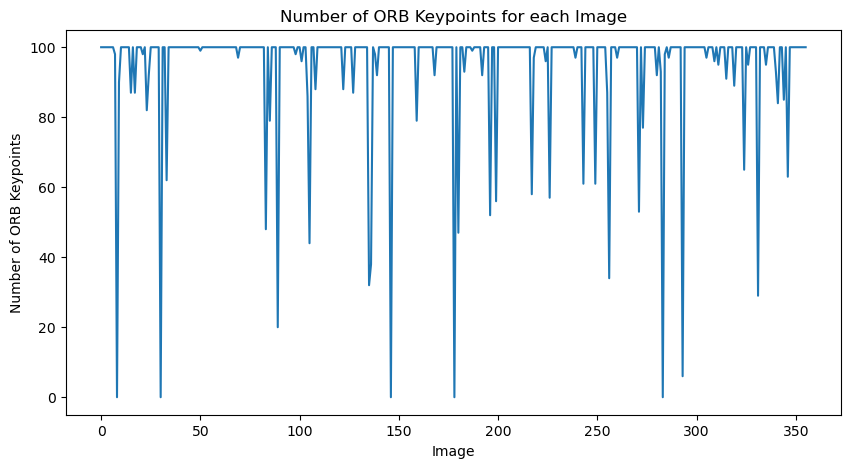

Number of images with exactly 100 keypoints:  289
Number of images with less than 100 keypoints:  19
Number of images with 0 keypoints:  5


In [13]:
# Initialize ORB
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Path to image folder
image_folder = dataset_processed_path

# Get list of image file names
image_files = os.listdir(image_folder)
# Filter the list to include only .jpg files
image_files = [file for file in image_files if file.endswith('.jpg')]

# Initialize lists to store image names and number of keypoints
image_names = []
num_keypoints = []
i = 0
num_images_100_keypoints = 0
num_images_less_than_100_keypoints = 0
num_0_keypoint = 0

# Iterate over each image
for image_file in image_files:
    # Load image
    image = cv.imread(os.path.join(image_folder, image_file), cv.IMREAD_GRAYSCALE)

    # Compute ORB descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        image_names.append(i)
        num_keypoints.append(0)
        num_images_less_than_100_keypoints += 1
        num_0_keypoint += 1
    else:
        # Store image name and number of keypoints
        image_names.append(i)
        num_keypoints.append(len(descriptors))
        if len(descriptors) == 100:
            num_images_100_keypoints += 1
        elif len(descriptors) < 60:
            num_images_less_than_100_keypoints += 1
    i = i+1

# Create plot
plt.figure(figsize=(10, 5))
plt.plot(image_names, num_keypoints)
plt.xlabel('Image')
plt.ylabel('Number of ORB Keypoints')
plt.title('Number of ORB Keypoints for each Image')  
plt.show()



print("Number of images with exactly 100 keypoints: ", num_images_100_keypoints)
print("Number of images with less than 100 keypoints: ", num_images_less_than_100_keypoints)
print("Number of images with 0 keypoints: ", num_0_keypoint)

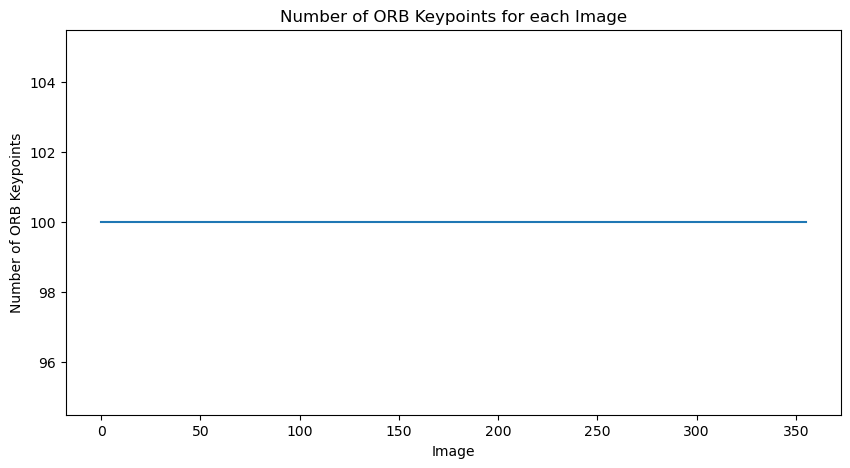

In [2]:
# Initialize ORB
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Path to image folder
image_folder = dataset_processed_path

# Get list of image file names
image_files = os.listdir(image_folder)
# Filter the list to include only .jpg files
image_files = [file for file in image_files if file.endswith('.jpg')]

# Initialize lists to store image names and number of keypoints
image_names = []
num_keypoints = []
i = 0
# Iterate over each image
for image_file in image_files:
    # Load image
    image = cv.imread(os.path.join(image_folder, image_file), cv.IMREAD_GRAYSCALE)

    # Compute ORB descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        # Initialize descriptors as an array of zeros
        descriptors = np.zeros((num_features, 32))
    else:
        if len(descriptors) < num_features:
            delta = num_features - len(descriptors)
            descriptors = np.concatenate((descriptors, np.zeros((delta, 32))))


    # Store image name and number of keypoints
    image_names.append(i)
    num_keypoints.append(len(descriptors))
    i = i+1

# Create plot
plt.figure(figsize=(10, 5))
plt.plot(image_names, num_keypoints)
plt.xlabel('Image')
plt.ylabel('Number of ORB Keypoints')
plt.title('Number of ORB Keypoints for each Image')  
plt.show()

### Create ORB dataset

In [43]:
# Initialize ORB
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Path to your image folder
image_folder = dataset_processed_path

# Get list of image file names
image_files = os.listdir(image_folder)
# Filter the list to include only .jpg files
image_files = [file for file in image_files if file.endswith('.jpg')]


# ORB dataset
orb_descriptors = []

# Initialize lists to store image names and number of keypoints
image_names = []
num_keypoints = []
i = 0
# Iterate over each image
for image_file in image_files:
    # Load image
    image = cv.imread(os.path.join(image_folder, image_file), 0)  # load in grayscale

    # Compute ORB descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        # Initialize descriptors as an array of zeros
        descriptors = np.zeros((num_features, 32))
    else:
        if len(descriptors) < num_features:
            delta = num_features - len(descriptors)
            descriptors = np.concatenate((descriptors, np.zeros((delta, 32))))
    
    # Add descriptors to ORB dataset list; if there are less than 100 keypoints, add zeros
    orb_descriptors.append(descriptors)

# Convert ORB dataset to numpy array (images, keypoints, features)
orb_descriptors = np.array(orb_descriptors, dtype=int)


In [44]:
np.save(dataset_processed_path + 'orb.npy', orb_descriptors)

In [5]:
orb_descriptors = np.load(dataset_processed_path + 'orb.npy')
print(orb_descriptors.dtype, orb_descriptors.shape)
print(orb_descriptors[0])


float64 (356, 100, 32)
[[  3. 141.  99. ... 142. 121. 140.]
 [ 36.  37. 130. ...  75. 176. 128.]
 [ 80. 201.  11. ...  58.  49.   8.]
 ...
 [216.  68. 174. ... 208. 240.  40.]
 [ 75. 147. 237. ... 196. 181. 121.]
 [184.  69. 102. ... 186. 240.   8.]]


# Image Retrieval

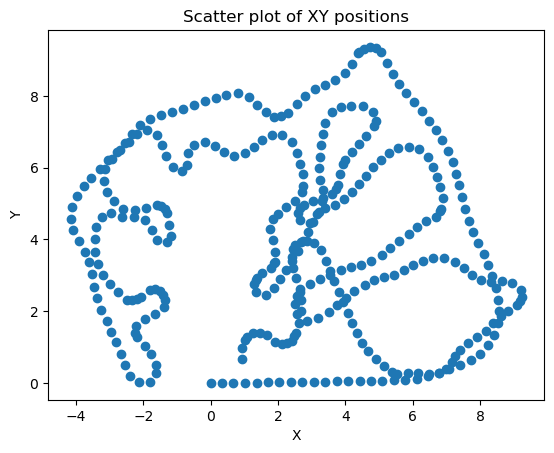

In [14]:
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')
positions = filtered_dataset[:, 1:3]

# Create scatter plot
plt.scatter(positions[:, 0], positions[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of XY positions')
plt.show()

### TEST 1 - Query 1 - top N

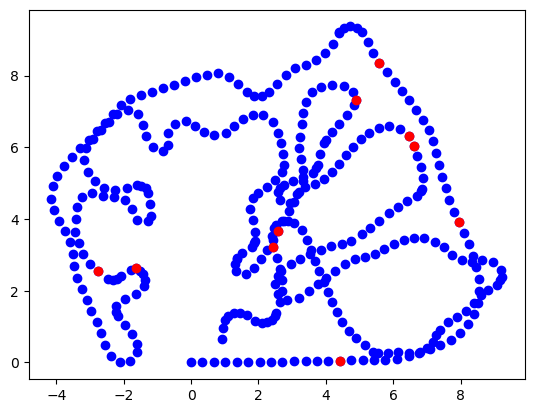

In [15]:
image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/test_1/'
image_reloc = cv.imread(image_reloc_path + 'image_reloc_0_1.jpg', cv.IMREAD_GRAYSCALE)

orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

N = 10

# Inizialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Calculate ORB descriptors for query image
_, descriptors_query = orb.detectAndCompute(image_reloc, None)
descriptors_query = descriptors_query.astype(np.uint8)
# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Store the number of matches for each image
matches_per_image = []

# Match the query image's descriptors with each database image's descriptors
# Match the query image's descriptors with each database image's descriptors
for i in range(orb_dataset.shape[0]):
    # Convert the descriptors to uint8
    db_descriptors = orb_dataset[i].astype(np.uint8)
    matches = bf.match(descriptors_query, db_descriptors)
    # Store the number of matches along with the image's index
    matches_per_image.append((len(matches), i))

# Sort by the number of matches (in descending order)
matches_per_image.sort(reverse=True)

# Select the top N images
top_N_images_1 = matches_per_image[:N]

# Get the poses of the top N images
top_N_poses_1 = filtered_dataset[[i for _, i in top_N_images_1]]

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(top_N_poses_1[:, 1], top_N_poses_1[:, 2], color='red')

plt.show()


### TEST 1 - Query 2 - top N

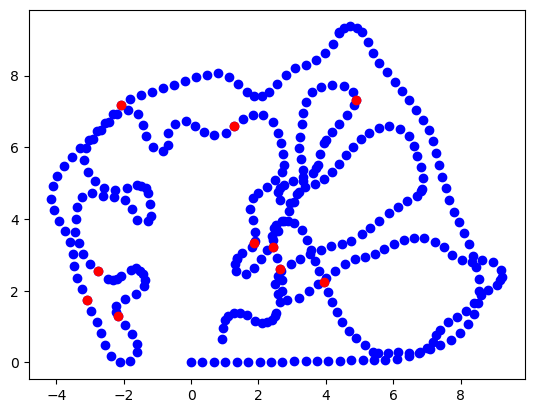

In [23]:
image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/test_1/'
image_reloc = cv.imread(image_reloc_path + 'image_reloc_0_2.jpg', cv.IMREAD_GRAYSCALE)

orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')


# Inizialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Calculate ORB descriptors for query image
_, descriptors_query = orb.detectAndCompute(image_reloc, None)
descriptors_query = descriptors_query.astype(np.uint8)
# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Store the number of matches for each image
matches_per_image = []

# Match the query image's descriptors with each database image's descriptors
# Match the query image's descriptors with each database image's descriptors
for i in range(orb_dataset.shape[0]):
    # Convert the descriptors to uint8
    db_descriptors = orb_dataset[i].astype(np.uint8)
    matches = bf.match(descriptors_query, db_descriptors)
    # Store the number of matches along with the image's index
    matches_per_image.append((len(matches), i))

# Sort by the number of matches (in descending order)
matches_per_image.sort(reverse=True)

# Select the top N images
top_N_images_2 = matches_per_image[:N]

# Get the poses of the top N images
top_N_poses_2 = filtered_dataset[[i for _, i in top_N_images_2]]

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(top_N_poses_2[:, 1], top_N_poses_2[:, 2], color='red')

plt.show()

### TEST 1 - Query 3 - top N

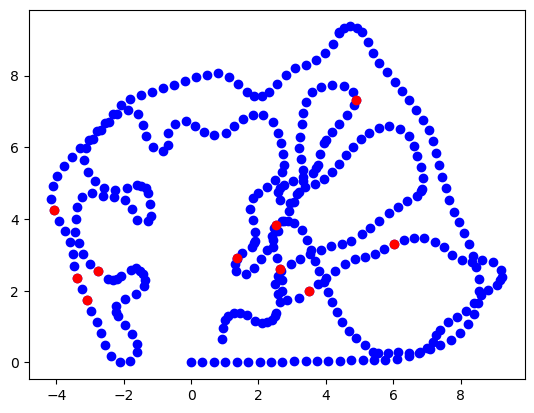

In [24]:
image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/test_1/'
image_reloc = cv.imread(image_reloc_path + 'image_reloc_0_3.jpg', cv.IMREAD_GRAYSCALE)

orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')


# Inizialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Calculate ORB descriptors for query image
_, descriptors_query = orb.detectAndCompute(image_reloc, None)
descriptors_query = descriptors_query.astype(np.uint8)
# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Store the number of matches for each image
matches_per_image = []

# Match the query image's descriptors with each database image's descriptors
# Match the query image's descriptors with each database image's descriptors
for i in range(orb_dataset.shape[0]):
    # Convert the descriptors to uint8
    db_descriptors = orb_dataset[i].astype(np.uint8)
    matches = bf.match(descriptors_query, db_descriptors)
    # Store the number of matches along with the image's index
    matches_per_image.append((len(matches), i))

# Sort by the number of matches (in descending order)
matches_per_image.sort(reverse=True)

# Select the top N images
top_N_images_3 = matches_per_image[:N]

# Get the poses of the top N images
top_N_poses_3 = filtered_dataset[[i for _, i in top_N_images_3]]

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(top_N_poses_3[:, 1], top_N_poses_3[:, 2], color='red')

plt.show()

### TEST 1 - Concatenation - top N

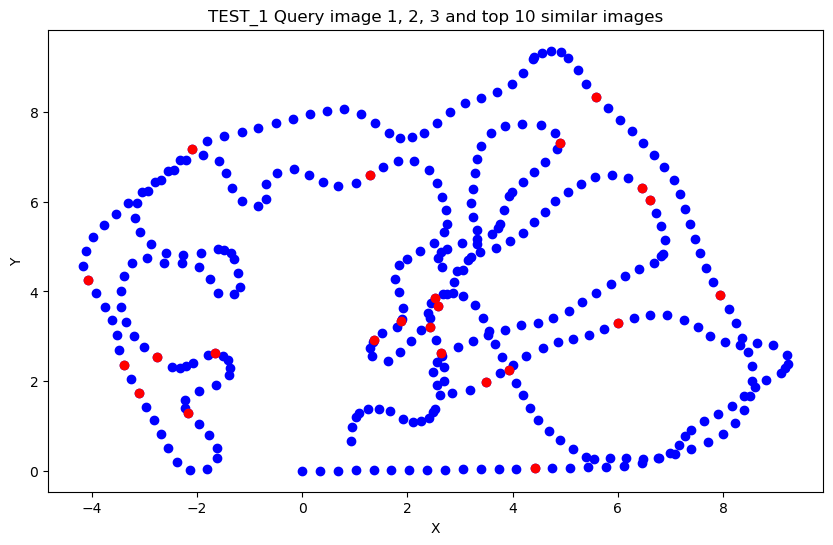

In [26]:
all_top_positions = np.concatenate((top_N_poses_1, top_N_poses_2, top_N_poses_3))
all_top_positions = np.unique(all_top_positions, axis=0)
#top_N_similarities = np.concatenate((top_N_similarities_1, top_N_similarities_2, top_N_similarities_3))
filtered_top_positions = all_top_positions

# Filter with DBSCAN
#clustering = DBSCAN(eps=0.5, min_samples=3).fit(all_top_positions)
#filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 1], filtered_top_positions[:, 2], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'TEST_1 Query image 1, 2, 3 and top {N} similar images')
plt.show()

### TEST 2 - Query 1 - top N

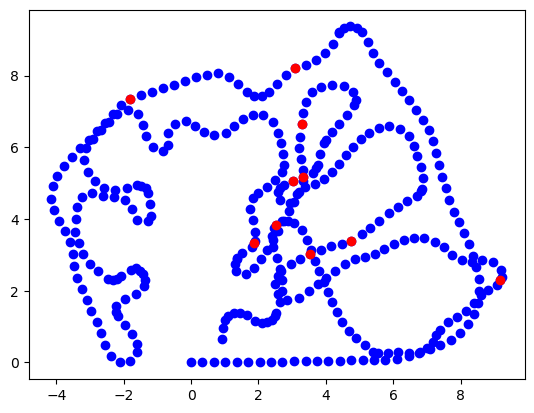

In [27]:
image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/test_2/'
image_reloc = cv.imread(image_reloc_path + 'image_reloc_0_1.jpg', cv.IMREAD_GRAYSCALE)

orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

N = 10

# Inizialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Calculate ORB descriptors for query image
_, descriptors_query = orb.detectAndCompute(image_reloc, None)
descriptors_query = descriptors_query.astype(np.uint8)
# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Store the number of matches for each image
matches_per_image = []

# Match the query image's descriptors with each database image's descriptors
# Match the query image's descriptors with each database image's descriptors
for i in range(orb_dataset.shape[0]):
    # Convert the descriptors to uint8
    db_descriptors = orb_dataset[i].astype(np.uint8)
    matches = bf.match(descriptors_query, db_descriptors)
    # Store the number of matches along with the image's index
    matches_per_image.append((len(matches), i))

# Sort by the number of matches (in descending order)
matches_per_image.sort(reverse=True)

# Select the top N images
top_N_images_1 = matches_per_image[:N]

# Get the poses of the top N images
top_N_poses_1 = filtered_dataset[[i for _, i in top_N_images_1]]

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(top_N_poses_1[:, 1], top_N_poses_1[:, 2], color='red')

plt.show()

### TEST 2 - Query 2 - top N

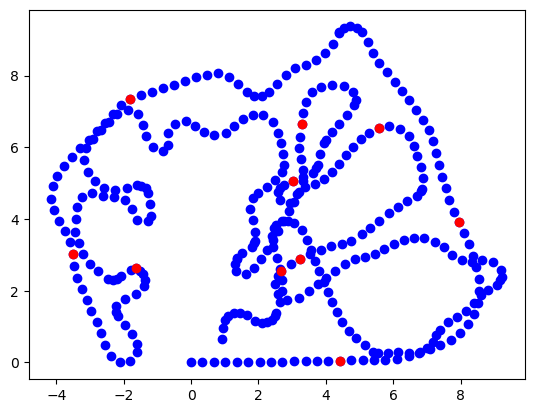

In [28]:
image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/test_2/'
image_reloc = cv.imread(image_reloc_path + 'image_reloc_0_2.jpg', cv.IMREAD_GRAYSCALE)

orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')


# Inizialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Calculate ORB descriptors for query image
_, descriptors_query = orb.detectAndCompute(image_reloc, None)
descriptors_query = descriptors_query.astype(np.uint8)
# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Store the number of matches for each image
matches_per_image = []

# Match the query image's descriptors with each database image's descriptors
for i in range(orb_dataset.shape[0]):
    # Convert the descriptors to uint8
    db_descriptors = orb_dataset[i].astype(np.uint8)
    matches = bf.match(descriptors_query, db_descriptors)
    # Store the number of matches along with the image's index
    matches_per_image.append((len(matches), i))

# Sort by the number of matches (in descending order)
matches_per_image.sort(reverse=True)

# Select the top N images
top_N_images_2 = matches_per_image[:N]

# Get the poses of the top N images
top_N_poses_2 = filtered_dataset[[i for _, i in top_N_images_2]]

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(top_N_poses_2[:, 1], top_N_poses_2[:, 2], color='red')

plt.show()

### TEST 2 - Query 3 - top N

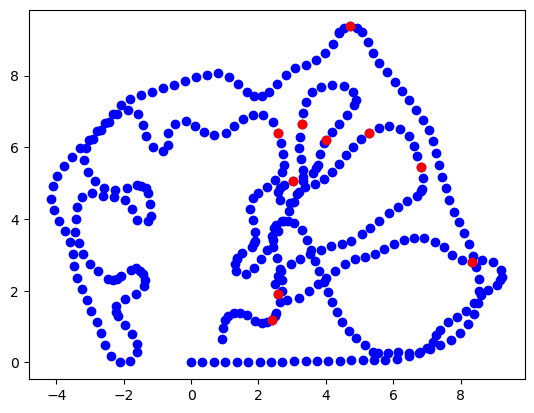

In [30]:
image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/test_2/'
image_reloc = cv.imread(image_reloc_path + 'image_reloc_0_3.jpg', cv.IMREAD_GRAYSCALE)

orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')


# Inizialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Calculate ORB descriptors for query image
_, descriptors_query = orb.detectAndCompute(image_reloc, None)
descriptors_query = descriptors_query.astype(np.uint8)
# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Store the number of matches for each image
matches_per_image = []

# Match the query image's descriptors with each database image's descriptors
# Match the query image's descriptors with each database image's descriptors
for i in range(orb_dataset.shape[0]):
    # Convert the descriptors to uint8
    db_descriptors = orb_dataset[i].astype(np.uint8)
    matches = bf.match(descriptors_query, db_descriptors)
    # Store the number of matches along with the image's index
    matches_per_image.append((len(matches), i))

# Sort by the number of matches (in descending order)
matches_per_image.sort(reverse=True)

# Select the top N images
top_N_images_3 = matches_per_image[:N]

# Get the poses of the top N images
top_N_poses_3 = filtered_dataset[[i for _, i in top_N_images_3]]

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(top_N_poses_3[:, 1], top_N_poses_3[:, 2], color='red')

plt.show()

### TEST 2 - Concatenation - top N

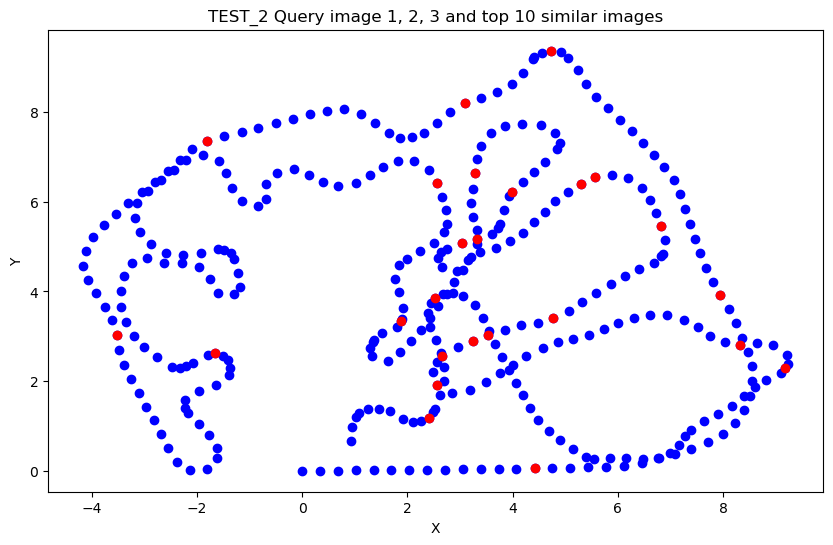

In [31]:
all_top_positions = np.concatenate((top_N_poses_1, top_N_poses_2, top_N_poses_3))
all_top_positions = np.unique(all_top_positions, axis=0)
#top_N_similarities = np.concatenate((top_N_similarities_1, top_N_similarities_2, top_N_similarities_3))
filtered_top_positions = all_top_positions

# Filter with DBSCAN
#clustering = DBSCAN(eps=0.5, min_samples=3).fit(all_top_positions)
#filtered_top_positions = all_top_positions[clustering.labels_ != -1]

# Plot all poses in blue
plt.figure(figsize=(10, 6))
plt.scatter(positions[:, 0], positions[:, 1], color='blue')
# Plot the top poses in red
plt.scatter(filtered_top_positions[:, 1], filtered_top_positions[:, 2], color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'TEST_2 Query image 1, 2, 3 and top {N} similar images')
plt.show()

### TEST 3

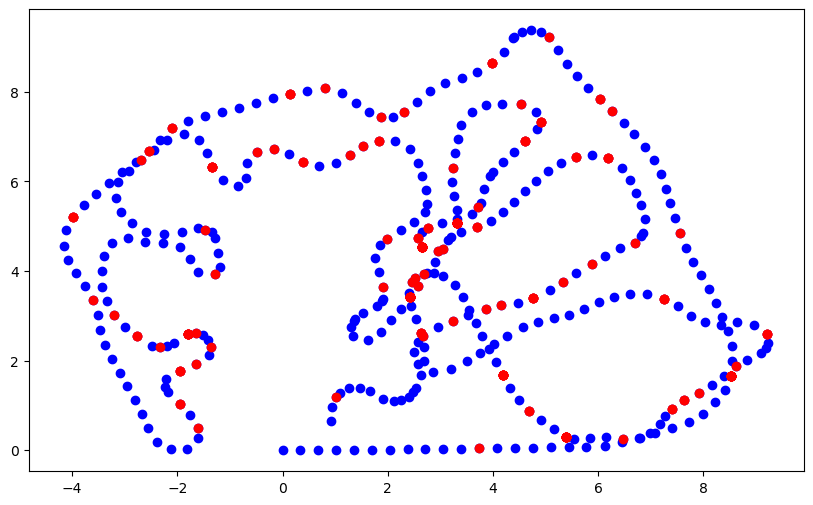

In [37]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

N = 10

# Inizialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Load the ORB dataset and filtered dataset
orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/test_3/'
query_images = os.listdir(image_reloc_path)

# Pre-load all query images
query_images = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in query_images]

# Initialize a list to store the top N poses for each query image
all_top_N_poses = []

for image_reloc in query_images:
    # Calculate ORB descriptors for the query image
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.uint8)

    # Store the number of matches for each image
    matches_per_image = np.zeros(orb_dataset.shape[0], dtype=int)

    # Match the query image's descriptors with each database image's descriptors
    for i in range(orb_dataset.shape[0]):
        # Convert the descriptors to uint8
        db_descriptors = orb_dataset[i].astype(np.uint8)
        matches = bf.match(descriptors_query, db_descriptors)
        # Store the number of matches
        matches_per_image[i] = len(matches)

    # Sort by the number of matches (in descending order)
    top_N_indices = np.argsort(matches_per_image)[::-1][:N]

    # Get the poses of the top N images
    top_N_poses = filtered_dataset[top_N_indices]

    # Add the top N poses to the list of all top N poses
    all_top_N_poses.append(top_N_poses)

# Convert the list of all top N poses to a numpy array
all_top_N_poses = np.concatenate(all_top_N_poses)

plt.figure(figsize=(10, 6))
# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(all_top_N_poses[:, 1], all_top_N_poses[:, 2], color='red')

plt.show()

# VGG16 + ORB

### Check if Tensorflow is using GPU

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

[]


2023-12-01 16:27:56.092720: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-01 16:27:56.092813: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
from keras import backend as K

print(K.tensorflow_backend._get_available_gpus())

AttributeError: module 'keras.backend' has no attribute 'tensorflow_backend'

### VGG16 + ORB VPR

In [11]:
import os
import re
import cv2 as cv
import numpy as np
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing import image as kimage
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import time
from sklearn.cluster import DBSCAN
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'
dataset_file = 'filtered_dataset.npy' 
dataset_array = np.load(dataset_processed_path + dataset_file)

### TEST 1

1/1 [==============================] - 0s 138ms/step
VGG16: 0.8961317539215088 seconds
orb:  0.07918405532836914 seconds


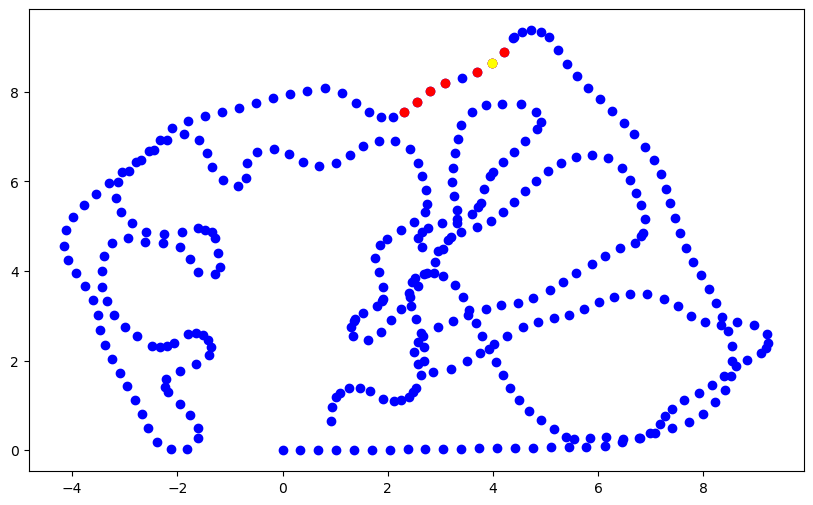

In [41]:

filter = True
N = 5
test = 'test_1'
# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Load VGG16, ORB dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

# TIMER VGG16
start_time_vgg16 = time.time()
### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]

# Stop the timer
end_time_vgg16 = time.time()
# Calculate the elapsed time
elapsed_time_vgg16 = end_time_vgg16 - start_time_vgg16

# TIMER orb
start_time_orb = time.time()
### Calculate ORB descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_orb:
    
    # Calculate ORB descriptors for the query image
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.uint8)
    
    # Store the number of matches for each image
    matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to uint8
        db_descriptors = orb_dataset[index].astype(np.uint8)
        # Match the descriptors
        matches = bf.match(descriptors_query, db_descriptors)
        # Store the number of matches
        matches_per_image[i] = len(matches)


# Get the index of the image with the most matches
best_match_index = np.argmax(matches_per_image)

# Get the pose of the best match
best_match_pose = filtered_dataset[top_indices_all_queries[best_match_index]]
# Stop the timer orb
end_time_orb = time.time()
# Calculate the elapsed time
elapsed_time_orb = end_time_orb - start_time_orb
print(f"VGG16: {elapsed_time_vgg16} seconds")
print(f"orb:  {elapsed_time_orb} seconds")

plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after ORB in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')

plt.show()

### TEST 2

In [33]:
# Start the timer
start_time = time.time()
filter = True
N = 5
test = 'test_2'
# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Load VGG16, ORB dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]

### Calculate ORB descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_orb:
    
    # Calculate ORB descriptors for the query image
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.uint8)
    
    # Store the number of matches for each image
    matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to uint8
        db_descriptors = orb_dataset[index].astype(np.uint8)
        # Match the descriptors
        matches = bf.match(descriptors_query, db_descriptors)
        # Store the number of matches
        matches_per_image[i] = len(matches)


# Get the index of the image with the most matches
best_match_index = np.argmax(matches_per_image)

# Get the pose of the best match
best_match_pose = filtered_dataset[top_indices_all_queries[best_match_index]]

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"The code executed in {elapsed_time} seconds")

# Append the best match pose to the list
#all_top_N_poses_vgg16.append(best_match_pose)

# Convert the list of best poses to numpy array
#all_top_N_poses_vgg16 = np.array(all_top_N_poses_vgg16)

plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after ORB in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')

plt.show()

1/1 [==============================] - 0s 98ms/step


ValueError: attempt to get argmax of an empty sequence

### TEST 3

1/1 [==============================] - 0s 98ms/step
The code executed in 3.645690679550171 seconds


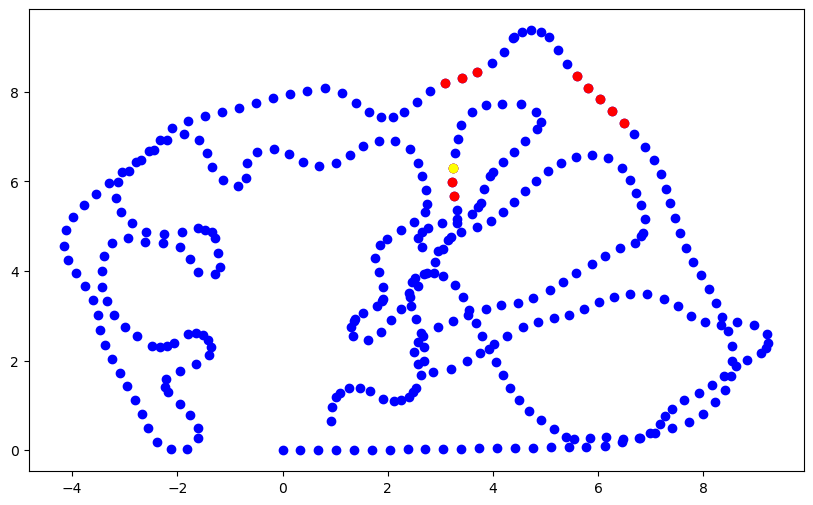

In [34]:
# Start the timer
start_time = time.time()
filter = True
N = 5
test = 'test_3'
# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Load VGG16, ORB dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]

### Calculate ORB descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_orb:
    
    # Calculate ORB descriptors for the query image
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.uint8)
    
    # Store the number of matches for each image
    matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to uint8
        db_descriptors = orb_dataset[index].astype(np.uint8)
        # Match the descriptors
        matches = bf.match(descriptors_query, db_descriptors)
        # Store the number of matches
        matches_per_image[i] = len(matches)


# Get the index of the image with the most matches
best_match_index = np.argmax(matches_per_image)

# Get the pose of the best match
best_match_pose = filtered_dataset[top_indices_all_queries[best_match_index]]

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"The code executed in {elapsed_time} seconds")

# Append the best match pose to the list
#all_top_N_poses_vgg16.append(best_match_pose)

# Convert the list of best poses to numpy array
#all_top_N_poses_vgg16 = np.array(all_top_N_poses_vgg16)

plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after ORB in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')

plt.show()

### TEST 4

1/1 [==============================] - 0s 95ms/step
The code executed in 4.347353458404541 seconds


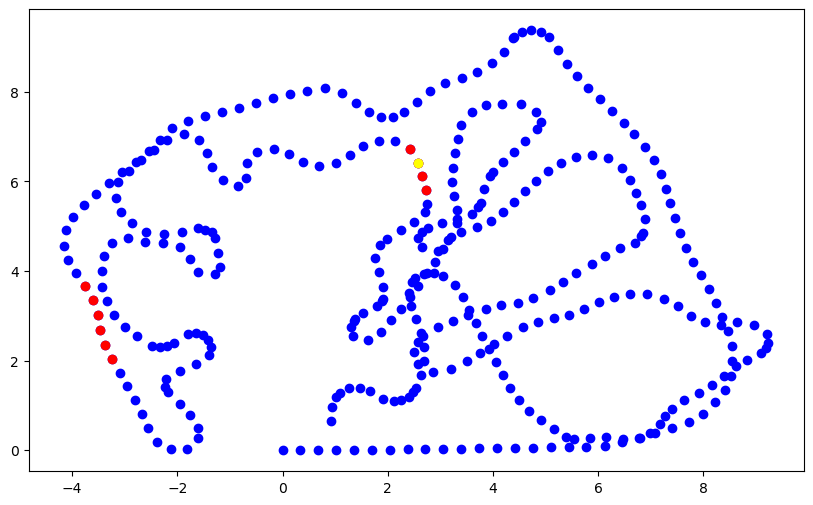

In [36]:
# Start the timer
start_time = time.time()
filter = True
N = 5
test = 'test_4'
# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Load VGG16, ORB dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]

### Calculate ORB descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_orb:
    
    # Calculate ORB descriptors for the query image
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.uint8)
    
    # Store the number of matches for each image
    matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to uint8
        db_descriptors = orb_dataset[index].astype(np.uint8)
        # Match the descriptors
        matches = bf.match(descriptors_query, db_descriptors)
        # Store the number of matches
        matches_per_image[i] = len(matches)


# Get the index of the image with the most matches
best_match_index = np.argmax(matches_per_image)

# Get the pose of the best match
best_match_pose = filtered_dataset[top_indices_all_queries[best_match_index]]

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"The code executed in {elapsed_time} seconds")



plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after ORB in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')

plt.show()

### TEST 5

1/1 [==============================] - 0s 103ms/step
The code executed in 4.335885286331177 seconds


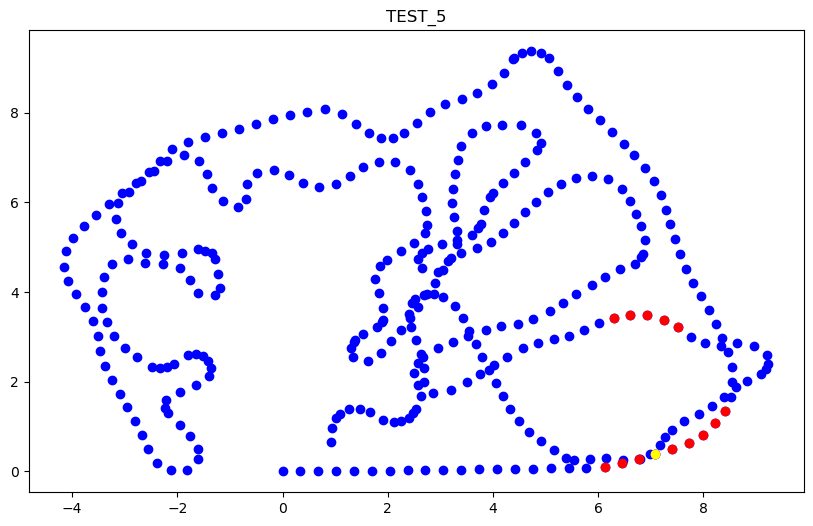

In [50]:
# Start the timer
start_time = time.time()
filter = True
N = 5
test = 'test_5'
# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Load VGG16, ORB dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]

### Calculate ORB descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_orb:
    
    # Calculate ORB descriptors for the query image
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.uint8)
    
    # Store the number of matches for each image
    matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to uint8
        db_descriptors = orb_dataset[index].astype(np.uint8)
        # Match the descriptors
        matches = bf.match(descriptors_query, db_descriptors)
        # Store the number of matches
        matches_per_image[i] = len(matches)


# Get the index of the image with the most matches
best_match_index = np.argmax(matches_per_image)

# Get the pose of the best match
best_match_pose = filtered_dataset[top_indices_all_queries[best_match_index]]

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"The code executed in {elapsed_time} seconds")

plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after ORB in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
plt.title(f'{test.upper()}')
plt.show()

### TEST 6

1/1 [==============================] - 0s 86ms/step
The code executed in 5.053376197814941 seconds


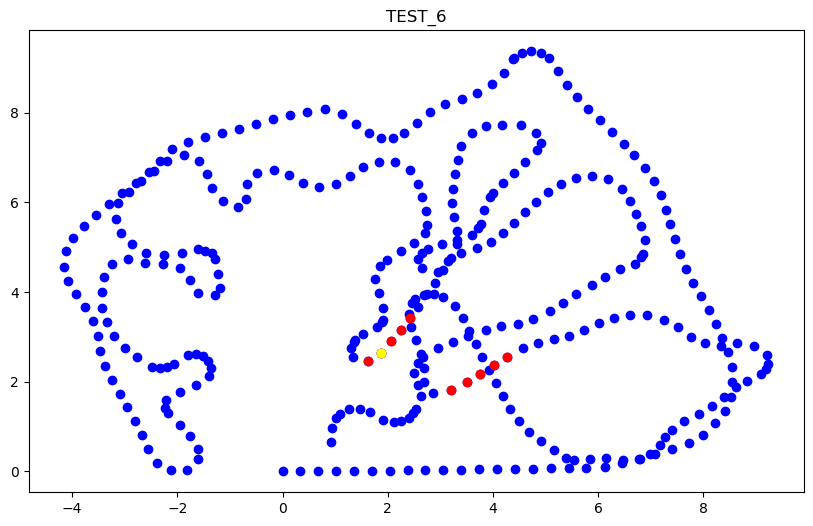

In [51]:
# Start the timer
start_time = time.time()
filter = True
N = 5
test = 'test_6'
# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize ORB detector
num_features = 100
orb = cv.ORB_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Load VGG16, ORB dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
orb_dataset = np.load(dataset_processed_path + 'orb.npy')
orb_dataset = orb_dataset.astype(np.uint8)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]

### Calculate ORB descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_orb:
    
    # Calculate ORB descriptors for the query image
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.uint8)
    
    # Store the number of matches for each image
    matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to uint8
        db_descriptors = orb_dataset[index].astype(np.uint8)
        # Match the descriptors
        matches = bf.match(descriptors_query, db_descriptors)
        # Store the number of matches
        matches_per_image[i] = len(matches)


# Get the index of the image with the most matches
best_match_index = np.argmax(matches_per_image)

# Get the pose of the best match
best_match_pose = filtered_dataset[top_indices_all_queries[best_match_index]]

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"The code executed in {elapsed_time} seconds")

plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after ORB in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
plt.title(f'{test.upper()}')
plt.show()

# VGG19 + ORB 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import os
import re

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-06 11:22:44.595617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 11:22:44.595673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 11:22:44.596533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 11:22:44.602035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

### TEST 1

1/1 [==============================] - 0s 142ms/step
VGG19: 1.08 seconds
ORB:  0.08 seconds
TOTAL:  1.159 seconds


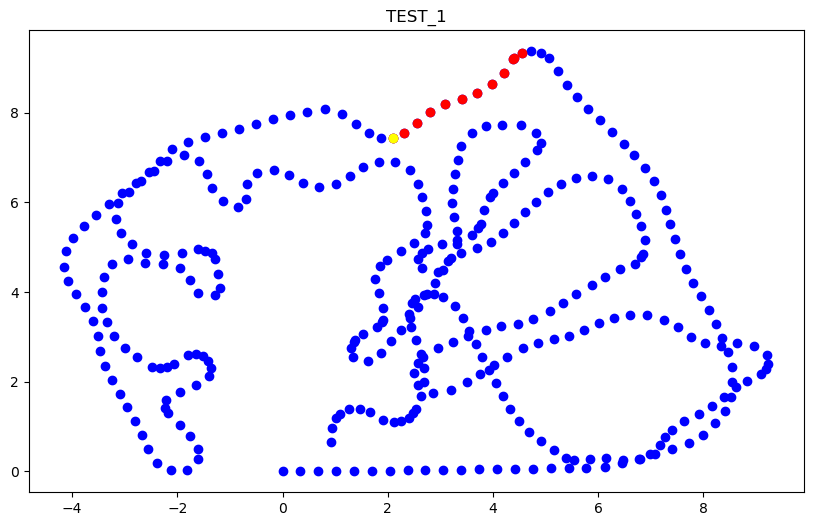

In [85]:
FILTER = True
N = 10
TEST = 'test_1'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_orb, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    for image_reloc in query_images_vgg19:
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        vgg19_feature = vgg19.predict(img_data)
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        top_indices_all_queries.extend(similarities.argsort()[:N])
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset):
    for image_reloc in query_images_orb:
        _, descriptors_query = orb.detectAndCompute(image_reloc, None)
        matches_per_image = [len(bf.match(descriptors_query.astype(np.uint8), orb_dataset[index].astype(np.uint8))) for index in top_indices_all_queries]
        return filtered_dataset[top_indices_all_queries[np.argmax(matches_per_image)]]

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, test):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    orb = cv.ORB_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    orb_dataset = np.load(dataset_processed_path + 'orb.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_orb, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # ORB processing
    start_time_orb = time.time()
    best_match_pose = process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset)
    end_time_orb = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"ORB:  {round(end_time_orb - start_time_orb, 3)} seconds") 
    print(f"TOTAL:  {round(end_time_orb - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, test)

### TEST 2

1/1 [==============================] - 0s 139ms/step
VGG19: 1.296 seconds
ORB:  0.04 seconds
TOTAL:  1.336 seconds


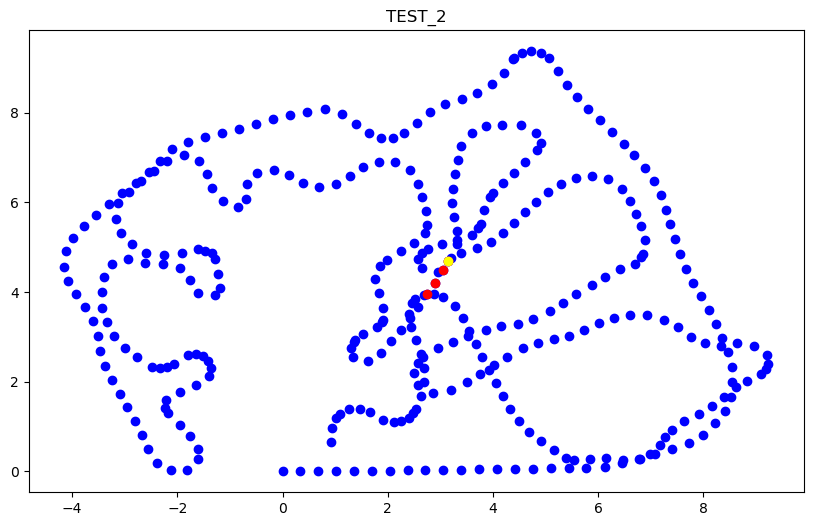

In [86]:
FILTER = True
N = 5
TEST = 'test_2'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_orb, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    for image_reloc in query_images_vgg19:
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        vgg19_feature = vgg19.predict(img_data)
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        top_indices_all_queries.extend(similarities.argsort()[:N])
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset):
    image_reloc = query_images_orb[-1]
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    matches_per_image = [len(bf.match(descriptors_query.astype(np.uint8), orb_dataset[index].astype(np.uint8))) for index in top_indices_all_queries]
    return filtered_dataset[top_indices_all_queries[np.argmax(matches_per_image)]]

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, test):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":


    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    orb = cv.ORB_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    orb_dataset = np.load(dataset_processed_path + 'orb.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_orb, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # ORB processing
    start_time_orb = time.time()
    best_match_pose = process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset)
    end_time_orb = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"ORB:  {round(end_time_orb - start_time_orb, 3)} seconds") 
    print(f"TOTAL:  {round(end_time_orb - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, test)

### TEST 3

1/1 [==============================] - 0s 145ms/step
VGG19: 5.808 seconds
ORB:  0.095 seconds
TOTAL:  5.903 seconds


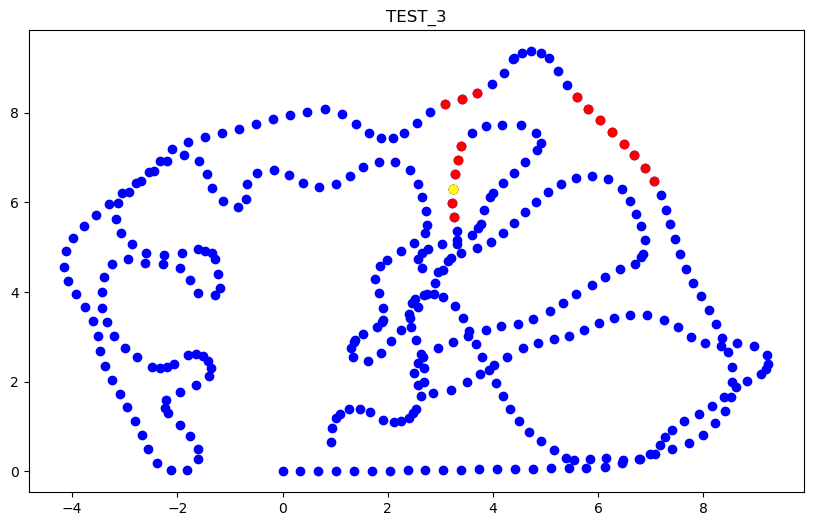

In [88]:
FILTER = True
N = 10
TEST = 'test_3'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_orb, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    for image_reloc in query_images_vgg19:
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        vgg19_feature = vgg19.predict(img_data)
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        top_indices_all_queries.extend(similarities.argsort()[:N])
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=1, min_samples=4).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset):
    image_reloc = query_images_orb[-1]
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    matches_per_image = [len(bf.match(descriptors_query.astype(np.uint8), orb_dataset[index].astype(np.uint8))) for index in top_indices_all_queries]
    return filtered_dataset[top_indices_all_queries[np.argmax(matches_per_image)]]

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    orb = cv.ORB_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    orb_dataset = np.load(dataset_processed_path + 'orb.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_orb, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # ORB processing
    start_time_orb = time.time()
    best_match_pose = process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset)
    end_time_orb = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"ORB:  {round(end_time_orb - start_time_orb, 3)} seconds") 
    print(f"TOTAL:  {round(end_time_orb - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

### TEST 4

1/1 [==============================] - 0s 149ms/step
VGG19: 5.973 seconds
ORB:  0.069 seconds
TOTAL:  6.041 seconds


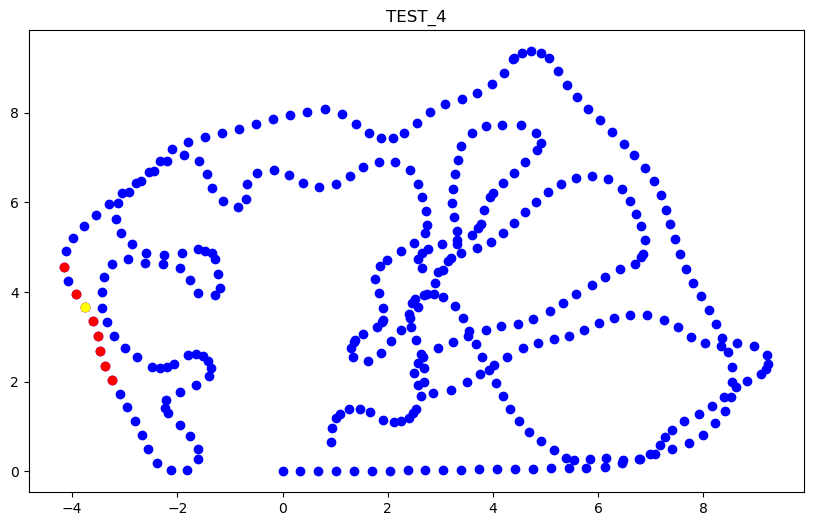

In [91]:
FILTER = True
N = 5
TEST = 'test_4'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_orb, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    for image_reloc in query_images_vgg19:
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        vgg19_feature = vgg19.predict(img_data)
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        top_indices_all_queries.extend(similarities.argsort()[:N])
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=1, min_samples=4).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset):
    image_reloc = query_images_orb[-1]
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    matches_per_image = [len(bf.match(descriptors_query.astype(np.uint8), orb_dataset[index].astype(np.uint8))) for index in top_indices_all_queries]
    return filtered_dataset[top_indices_all_queries[np.argmax(matches_per_image)]]

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    orb = cv.ORB_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    orb_dataset = np.load(dataset_processed_path + 'orb.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_orb, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # ORB processing
    start_time_orb = time.time()
    best_match_pose = process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset)
    end_time_orb = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"ORB:  {round(end_time_orb - start_time_orb, 3)} seconds") 
    print(f"TOTAL:  {round(end_time_orb - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

### TEST 5

1/1 [==============================] - 0s 152ms/step
VGG19: 5.814 seconds
ORB:  0.045 seconds
TOTAL:  5.859 seconds


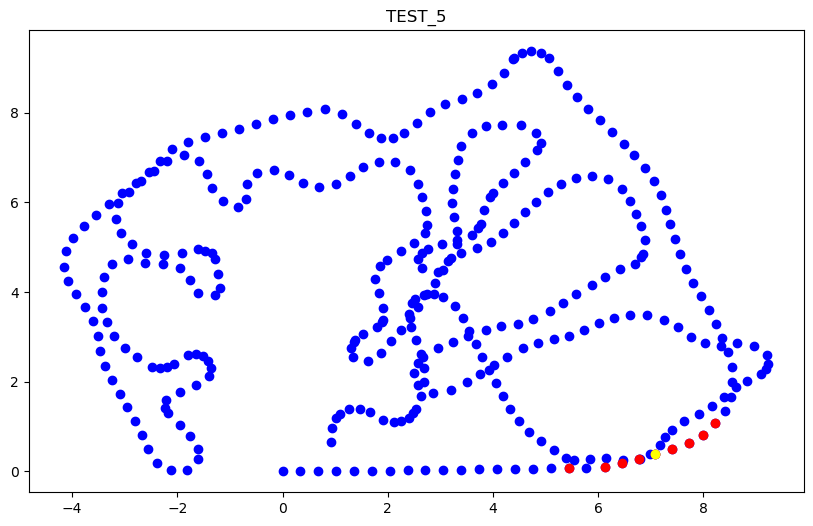

In [93]:
FILTER = True
N = 5
TEST = 'test_5'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_orb, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    for image_reloc in query_images_vgg19:
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        vgg19_feature = vgg19.predict(img_data)
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        top_indices_all_queries.extend(similarities.argsort()[:N])
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=1, min_samples=4).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset):
    image_reloc = query_images_orb[-1]
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    matches_per_image = [len(bf.match(descriptors_query.astype(np.uint8), orb_dataset[index].astype(np.uint8))) for index in top_indices_all_queries]
    return filtered_dataset[top_indices_all_queries[np.argmax(matches_per_image)]]

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    orb = cv.ORB_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    orb_dataset = np.load(dataset_processed_path + 'orb.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_orb, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # ORB processing
    start_time_orb = time.time()
    best_match_pose = process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset)
    end_time_orb = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"ORB:  {round(end_time_orb - start_time_orb, 3)} seconds") 
    print(f"TOTAL:  {round(end_time_orb - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

### TEST 6

1/1 [==============================] - 0s 19ms/step
VGG19: 4.721 seconds
ORB:  0.027 seconds
TOTAL:  4.747 seconds


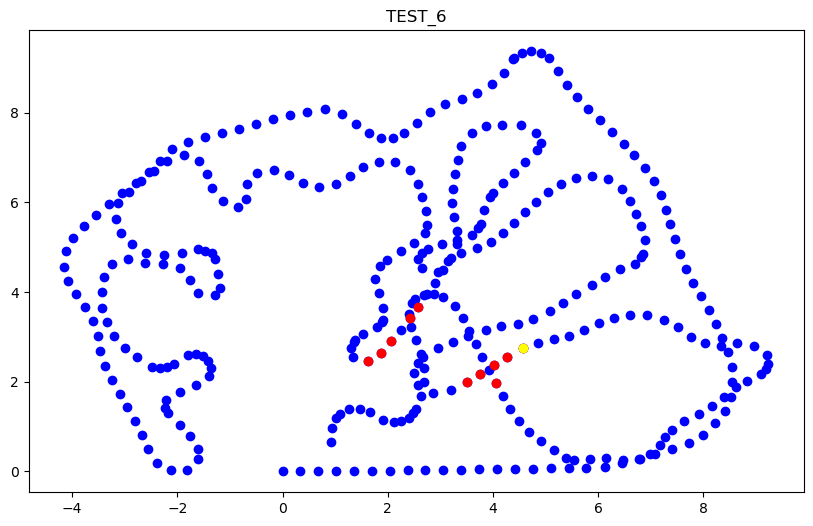

In [14]:
FILTER = True
N = 5
TEST = 'test_6'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_orb = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_orb, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    for image_reloc in query_images_vgg19:
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        vgg19_feature = vgg19.predict(img_data)
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        top_indices_all_queries.extend(similarities.argsort()[:N])
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=1, min_samples=4).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset):
    image_reloc = query_images_orb[-1]
    _, descriptors_query = orb.detectAndCompute(image_reloc, None)
    matches_per_image = [len(bf.match(descriptors_query.astype(np.uint8), orb_dataset[index].astype(np.uint8))) for index in top_indices_all_queries]
    return filtered_dataset[top_indices_all_queries[np.argmax(matches_per_image)]]

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    orb = cv.ORB_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    orb_dataset = np.load(dataset_processed_path + 'orb.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_orb, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # ORB processing
    start_time_orb = time.time()
    best_match_pose = process_orb(query_images_orb, orb, bf, orb_dataset, top_indices_all_queries, filtered_dataset)
    end_time_orb = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"ORB:  {round(end_time_orb - start_time_orb, 3)} seconds") 
    print(f"TOTAL:  {round(end_time_orb - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)